# AHRS

This Notebook showcases the most important classes and functions included in the Python package `ahrs`.

Here we will explore the basic use of:

- Class [DCM](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html)
- Class [Quaternion](https://ahrs.readthedocs.io/en/latest/quaternion/classQuaternion.html)
- Class [QuaternionArray](https://ahrs.readthedocs.io/en/latest/quaternion/classQuaternionArray.html)
- Some [Attitude estimation algorithms](https://ahrs.readthedocs.io/en/latest/filters.html)
- The [World Magnetic Model](https://ahrs.readthedocs.io/en/latest/wmm.html)
- The [World Geodetic System](https://ahrs.readthedocs.io/en/latest/wgs84.html)
- [Metrics functions](https://ahrs.readthedocs.io/en/latest/metrics.html) for orientation representations.
- And diverse tools included in `ahrs`.

## Helping Packages

Plotting and data-handling tools are imported from the script `tools.py` located in the current directory. These tools simplify the visualization of orientations in 3d, or time-series data, but are **NOT** included in the `ahrs` package.

Packages `matplotlib` and `ipympl` are required to build interactive visualizations in the Notebook. Make sure you have those installed.

Once you have `ahrs` installed (which also installs `numpy`) and you have the forementioned libraries, we can start by setting our notebook up.

In [1]:
# Use widgets
%matplotlib widget

# Import NumPy
import numpy as np

# Seed random generator
GENERATOR = np.random.default_rng(42)

# Import plotting tools
from tools import plot
from tools import plot3

### Helping functions

The plotting functions imported from the script `tools.py` in the current directory simplify the visualization of orientations in 3d, or time-series data. These two functions are:

- `plot` shows time-series data in vertically stacked plots.
- `plot3` shows a 3D scene, where particles, frames, and items exist and interact in the same space.

These functions use `matplotlib` with the `ipympl` backend to use interactive visualizations in the Notebook. Make sure you have those installed.

## AHRS Basics

We can start now. Let's import our favorite package.

In [2]:
import ahrs

## Attitude Representations

The first elements we want to manipulate and use are the representations of any Attitude (that's the "A" in AHRS.)

There are many ways to mathematically represent the attitude:

1. Direction Cosine Matrix.
2. Euler Angles.
3. Axis-Angle.
4. Quaternion.

Let's check the most intuitive first.

### Direction Cosine Matrix

The [Direction Cosine Matrix](https://ahrs.readthedocs.io/en/latest/dcm.html)can be built with the class [DCM](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html). This represents either:

- the **orientation** of a frame in 3D space with respect to another reference frame in the same space, or
- the **linear operation**, where a point (or points) is (are) rotated according the rotation described in the DCM.

Normally the global frame is represented by the 3x3 Identity matrix.

Global frame:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


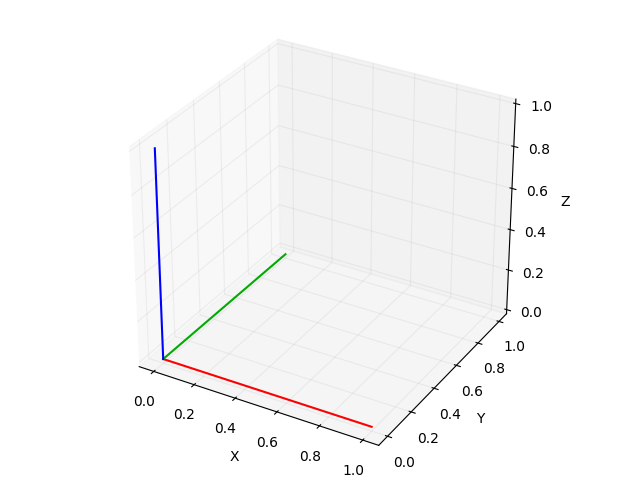

In [3]:
global_frame = ahrs.DCM()    # An empty DCM is initialized as the global frame
print("Global frame:")
print(global_frame.view())
plot3(frames=global_frame)

As you can see, any frame in 3D can be visualized with three orthogonal axes of length one. The X-, Y-, and Z-axis are represented with red, green and blue color, respectively.

Each axis is described in the columns of the DCM:

$$
\begin{bmatrix}
  \color{red}{|} &  \color{green}{|} & \color{blue}{|} \\
  \color{red}{X} &  \color{green}{Y} & \color{blue}{Z} \\
  \color{red}{|} &  \color{green}{|} & \color{blue}{|}
 \end{bmatrix}
$$

To make it easier. Imagine:

- The first column describes the three-dimensional postition of the X-axis tip (red)
- The second column describes the three-dimensional postition of the Y-axis tip (green)
- The third column describes the three-dimensional postition of the Z-axis tip (blue)

Go back up and see that the visualized frame actually describes the columns of the global frame.

$$
\begin{array}{lcr}
X = \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix} &
Y = \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix} &
Z = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}
\end{array}
$$

The class `DCM` works in radians. If you want to use degrees, you can transform your values with the helper constant `DEG2RAD`.

Now let's built a matrix describing a rotation of 45° about the Z-axis, and confirm that its elements describe the position of each Axis' tip.

Rotation of 45° about global frame's Z-axis:
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


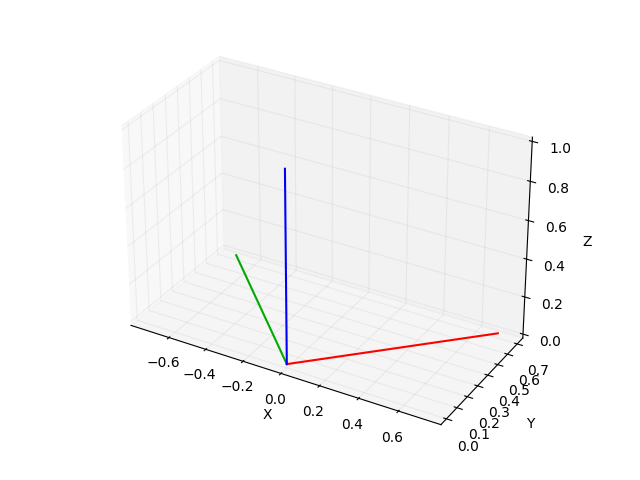

In [4]:
rotated_frame = ahrs.DCM(z=45.0*ahrs.DEG2RAD)    # DCM rotated 45 degrees (see helper constant) about the Z-axis
print("Rotation of 45° about global frame's Z-axis:")
print(rotated_frame.view())
plot3(frames=rotated_frame)

You see the Z-axis (blue) remains unchanged, while the other points rotate around it, as expected.

The class `DCM` is derived from [NumPy arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html), and its attributes and methods are kept.

The DCM's characteristics in SO(3) are conveniently added. Operations between DCMs yield DCMs too.

You can also build the DCM, by giving it any valid $3\times 3$ orthogonal matrix in SO(3). It will fail if it is not valid.

In [5]:
valid_rotation = ahrs.DCM(np.array([[np.sqrt(2)/2, -np.sqrt(2)/2, 0], [np.sqrt(2)/2, np.sqrt(2)/2, 0], [0, 0, 1]]))
valid_rotation.view()

DCM([[ 0.70710678, -0.70710678,  0.        ],
     [ 0.70710678,  0.70710678,  0.        ],
     [ 0.        ,  0.        ,  1.        ]])

In [6]:
invalid_rotation = ahrs.DCM(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]))

ValueError: Given attitude is not in SO(3)

### Euler Angles

DCMs can be built in different ways, the most famous one is through Euler Angles.

These angles, first introduced by [Leonhard Euler](https://en.wikipedia.org/wiki/Leonhard_Euler) are three angles describing the orientation of an object with respect to a fixed coordinate system.

Three composed (chained) **elemental rotations** are always sufficient to reach any frame in 3D space. In this case, we can build each rotation separately with our class `DCM` by setting it in its constructor.

The chained multiplication of these orientations yields a final composed orientation.

Because the rotation operations are **always with respect to the initial global frame**, it is called an **[Extrinsic rotation](https://en.wikipedia.org/wiki/Euler_angles#Conventions_by_extrinsic_rotations)**.

In [7]:
print("Rotation of 10 degrees about X-axis:")
print(ahrs.DCM(x=10.0*ahrs.DEG2RAD))

print("Rotation of 20 degrees about Y-axis:")
print(ahrs.DCM(y=20.0*ahrs.DEG2RAD))

print("Rotation of 30 degrees about Z-axis:")
print(ahrs.DCM(z=30.0*ahrs.DEG2RAD))

# New rotation matrix from products of rotations about X-, Y-, and Z-axis, respectively.
# Order of matrix multiplication is right to left: x --> y --> z
orientation = ahrs.DCM(z=30.0*ahrs.DEG2RAD) @ ahrs.DCM(y=20.0*ahrs.DEG2RAD) @ ahrs.DCM(x=10.0*ahrs.DEG2RAD)

print(f"Rotation Matrix {type(orientation)}:")
print(orientation)

Rotation of 10 degrees about X-axis:
[[ 1.          0.          0.        ]
 [ 0.          0.98480775 -0.17364818]
 [ 0.          0.17364818  0.98480775]]
Rotation of 20 degrees about Y-axis:
[[ 0.93969262  0.          0.34202014]
 [ 0.          1.          0.        ]
 [-0.34202014  0.          0.93969262]]
Rotation of 30 degrees about Z-axis:
[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]
Rotation Matrix <class 'ahrs.common.dcm.DCM'>:
[[ 0.81379768 -0.44096961  0.37852231]
 [ 0.46984631  0.88256412  0.01802831]
 [-0.34202014  0.16317591  0.92541658]]


This proces can be simplified at creation of the DCM object setting the [Euler angles](https://en.wikipedia.org/wiki/Euler_angles) tuple:

In [8]:
orientation = ahrs.DCM( euler=('zyx', np.array([30.0, 20.0, 10.0])*ahrs.DEG2RAD) )
orientation.view()

DCM([[ 0.81379768, -0.44096961,  0.37852231],
     [ 0.46984631,  0.88256412,  0.01802831],
     [-0.34202014,  0.16317591,  0.92541658]])

As you can see, for the Euler angles we tried to match the mathematical order of multiplication from right to left.

The custom class [DCM](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html) includes the basic attributes describing the mathematical properties of a DCM.

In [9]:
attribute_list = ['T', 'I', 'inv', 'det', 'determinant', 'fro', 'frobenius', 'adj', 'adjugate', 'log']
for attribute_name in attribute_list:
    print(f"rotation.{attribute_name} =")
    print(orientation.__getattribute__(attribute_name), '\n')

rotation.T =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.I =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.inv =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.det =
1.0000000000000002 

rotation.determinant =
1.0000000000000002 

rotation.fro =
1.7320508075688772 

rotation.frobenius =
1.7320508075688772 

rotation.adj =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.adjugate =
[[ 0.81379768  0.46984631 -0.34202014]
 [-0.44096961  0.88256412  0.16317591]
 [ 0.37852231  0.01802831  0.92541658]] 

rotation.log =
[[ 0.          0.48647923 -0.38485157]
 [-0.48647923  0.          0.07752532]
 [ 0.38485157 -0.07752532  0.        ]] 



For a full detail of its properties, see its [documentation](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html).

On top of that, it has a plethora of methods that help us to get extra information.

In [10]:
# List all DCM methods and the first descriptive line from each docstring
from tools import describe_methods
describe_methods(orientation)

DCM.all()                Returns True if all elements evaluate to True.
DCM.any()                Returns True if any of the elements of `a` evaluate to True.
DCM.argmax()             Return indices of the maximum values along the given axis.
DCM.argmin()             Return indices of the minimum values along the given axis.
DCM.argpartition()       Returns the indices that would partition this array.
DCM.argsort()            Returns the indices that would sort this array.
DCM.astype()             Copy of the array, cast to a specified type.
DCM.byteswap()           Swap the bytes of the array elements
DCM.choose()             Use an index array to construct a new array from a set of choices.
DCM.clip()               Return an array whose values are limited to ``[min, max]``.
DCM.compress()           Return selected slices of this array along given axis.
DCM.conj()               Complex-conjugate all elements.
DCM.conjugate()          Return the complex conjugate, element-wise.
DCM.copy

Have a look at the documentation of the class [DCM](https://ahrs.readthedocs.io/en/latest/dcm/classDCM.html) for more details about the most important methods.